Evaluation of the frame-based matching algorithm
================================================

This notebook aims at evaluating the performance of the Markov Random Field (MRF) algorithm implemented in `stereovis/framed/algorithms/mrf.py` on three datasets. See the written report for a more detailed description of the datasets. 

A brief summary of the conducted experiments:
* running MRF on each dataset without any SNN-based prior 
* running MRF with prior initialisation from best-performing SNN configuration
* running MRF with prior initialisation and adjustment from motion
* comparing difference between the above scenarios and visually assessing their quality for no ground truth is recorded or computed.

In order to run the notebook, make sure to have the appropriate folder structure, or adjust the import statements and hard-coded paths in the functions below.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sys
import skimage.io as skio
import os

from skimage import transform, filters, feature, morphology

sys.path.append("../")
from stereovis.framed.algorithms.mrf import StereoMRF
from stereovis.spiking.algorithms.vvf import VelocityVectorField
from stereovis.utils.frames_io import load_frames, load_ground_truth, generate_frames_from_spikes, split_frames_by_time
from stereovis.utils.spikes_io import load_spikes
from stereovis.utils.config import load_config

/Users/admin/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Let's define some usefull evaluation and helper functions, that can be run on every dataset given the respective configuration file. In order to change the experiment, change the `experiment_name.yaml` file that is located in `experiments/config/hybrid`. 

In [3]:
def load_mrf_frames(config):
    """
    Load the images used for the frame-based matching. 
    
    Args:
        config: dict, configuration object. Should be loaded beforehand. 
    
    Returns:
        A tuple of numpy arrays with the left-camera frames, right-camera frames and the timestamps 
        provided by the left-camera.
    """
    frames_left, times = load_frames(input_path=os.path.join('..', config['input']['frames_path'], 'left'),
                                     resolution=config['input']['resolution'],
                                     crop_region=config['input']['crop'],
                                     scale_down_factor=config['input']['scale_down_factor'],
                                     simulation_time=config['simulation']['duration'],
                                     timestamp_unit=config['input']['timestamp_unit'],
                                     adjust_contrast=True)
    frames_right, _ = load_frames(input_path=os.path.join('..', config['input']['frames_path'], 'right'),
                                  resolution=config['input']['resolution'],
                                  crop_region=config['input']['crop'],
                                  scale_down_factor=config['input']['scale_down_factor'],
                                  simulation_time=config['simulation']['duration'],
                                  timestamp_unit=config['input']['timestamp_unit'],
                                  adjust_contrast=True)
    return frames_left, frames_right, times 

def load_retina_spikes(config, build_frames=True, pivots=None, buffer_length=10):
    """
    Load the events used for visualisation purposes. 
    
    Args:
        config: dict, configuration object.
        build_frames: bool, whether to load the events in buffered frame-wise manner or as a continuous stream. 
        pivots: list, timestamps which serve as ticks to buffer the events in frames at precise locations. 
            Otherwise, equdistant buffering will be performed, according to the buffer length.
        buffer_length: int, buffer span time in ms.
        
    Returns:
        Buffered left and right retina events, or non-buffered numpy array.
        
    Notes:
        The SNN's output is assumed fixed for this evaluation
        and only the MRF tests are performed. To experiment with the SNN, please see the framework. 
    """
    retina_spikes = load_spikes(input_file=os.path.join('..', config['input']['spikes_path']),
                                resolution=config['input']['resolution'],
                                crop_region=config['input']['crop'],
                                simulation_time=config['simulation']['duration'],
                                timestep_unit=config['input']['timestamp_unit'],
                                dt_thresh=1,
                                scale_down_factor=config['input']['scale_down_factor'],
                                as_spike_source_array=False)
    if not build_frames:
        return retina_spikes
    
    effective_frame_resolution = (np.asarray(config['input']['resolution']) 
                                  / config['input']['scale_down_factor']).astype(np.int32)

    retina_frames_l, times_l = \
        generate_frames_from_spikes(resolution=effective_frame_resolution,
                                    xs=retina_spikes['left'][:, 1],
                                    ys=retina_spikes['left'][:, 2],
                                    ts=retina_spikes['left'][:, 0],
                                    zs=retina_spikes['left'][:, 3],
                                    time_interval=buffer_length,
                                    pivots=pivots,
                                    non_pixel_value=-1)

    retina_frames_r, times_r = \
        generate_frames_from_spikes(resolution=effective_frame_resolution,
                                    xs=retina_spikes['right'][:, 1],
                                    ys=retina_spikes['right'][:, 2],
                                    ts=retina_spikes['right'][:, 0],
                                    zs=retina_spikes['right'][:, 3],
                                    time_interval=buffer_length,
                                    pivots=pivots,
                                    non_pixel_value=-1)
    assert retina_frames_l.shape == retina_frames_r.shape
    return retina_spikes, retina_frames_l, retina_frames_r

def load_snn_spikes(spikes_file, build_frames=True, pivots=None, 
                    buffer_length=10, non_pixel_value=-1):
    """
    Load the SNN output events used as a prior for the frame-based matching.
    
    Args:
        spikes_file: str, filepath for the SNN output events.
        build_frames: bool, whether to buffer the events as frames.
        pivots: list, timestamps for the frames.
        buffer_length: int, buffered frame time span in ms
        non_pixel_value: numerical value for the frame pixels for which there is no event
        
    Returns:
        Buffered frames, timestamps and indices of the events that hass been buffered in each frame accordingly.
    """
    prior_disparities = load_spikes(spikes_file)
    if not build_frames:
        return prior_disparities
    
    effective_frame_resolution = prior_disparities['meta']['resolution']
    prior_frames, timestamps, prior_frame_indices = \
        generate_frames_from_spikes(resolution=effective_frame_resolution,
                                    xs=prior_disparities['xs'],
                                    ys=prior_disparities['ys'],
                                    ts=prior_disparities['ts'],
                                    zs=prior_disparities['disps'],
                                    time_interval=buffer_length,
                                    pivots=pivots,
                                    non_pixel_value=non_pixel_value,
                                    return_time_indices=True)
    return prior_frames, timestamps, prior_frame_indices
    
    
def eval_mrf(left_img, right_img, max_disp, prior=None, 
             prior_mode='adaptive', prior_const=1.0, n_iter=10, 
             show_outline=False, show_plots=True):
    """
    Run the MRF frame-based matching from given frames and algorithm parameters.
    
    Args:
        left_img: 2d array with the pre-processed left image
        right_img: 2d array with the pre-processed right image
        max_dist: int, largest detectable disparity value
        prior: optionally a 2d array with the prior frame oriented to the left image
        prior_mode: str, mode of incorporating the prior frame. Can be 'adaptive' for mixing proportionally to the 
            data cost, or 'const' for normal mixing.
        prior_const: float, if the prior mode is 'const', this is the mixing coefficient.
        n_iter: int, number of BP iterations 
        show_outline: bool, whether to plot the outline of the objects (using Canny filter)
        show_plots: bool, whether to plot the results
    
    Returns:
        A 2d numpy array with the resulted disparity map.
    """
    img_res = left_img.shape
    mrf = StereoMRF(img_res, n_levels=max_disp)
    disp_map = mrf.lbp(left_img, right_img, prior=prior, 
                       prior_influence_mode=prior_mode, 
                       prior_trust_factor=prior_const,
                       n_iter=n_iter).astype(np.float32)
    disp_map[:, :max_disp] = np.nan
    if not show_plots:
        return disp_map
    
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(10, 8)
    axs[0, 0].imshow(left_img, interpolation='none', cmap='gray')
    axs[0, 0].set_title("Left frame")
    axs[0, 1].imshow(right_img, interpolation='none', cmap='gray')
    axs[0, 1].set_title("Right frame")
    print("Image resolution is: {}".format(img_res))
    
    if show_outline:
        val = filters.threshold_otsu(left_img)
        ref_shape = (left_img > val).reshape(img_res).astype(np.float32)
        ref_outline = feature.canny(ref_shape, sigma=1.0) > 0
        disp_map[ref_outline] = np.nan

    cmap = plt.cm.jet
    cmap.set_bad((1, 1, 1, 1))
    
    depth_map_im = axs[1, 0].imshow(disp_map, interpolation='none')
    axs[1, 0].set_title("Depth frame")
    depth_map_pos = axs[1, 0].get_position()
    cbaxes = plt.axes([depth_map_pos.x0*1.05 + depth_map_pos.width * 1.05, 
                       depth_map_pos.y0, 0.01, depth_map_pos.height])
    fig.colorbar(depth_map_im, cax=cbaxes)
    axs[1, 1].set_visible(False)
    return disp_map

def adjust_events_from_motion(retina_spikes, depth_events, 
                              adjustable_frame_id, frame_resolution, 
                              pivots, buffer_length):
    """
    Modify the position of the events according to the detected motion. As the algorithm for optical flow
    operates on the 3d non-buffered retina events, some additional parameters such as frame resolution etc. will
    be required (unfortunately they cannot be inferred).
    
    Args:
        retina_spikes: numpy array of the retina events which are used to extract the motion vectors.
        depth_events: numpy array with the SNN events (as frames) that should be adjusted.
        adjustable_frame_id: int, the id of the frame that should be modified.
        frame_resolution: tuple of the resolution of the prior frame
        pivots: list, timestamps of the prior frames
        buffer_length: int, time in ms for the length of the buffered frames.
    
    Returns:
        One adjusted prior frame.
    """
    vvf = VelocityVectorField(time_interval=buffer_length, 
                              neighbourhood_size=(3, 3), 
                              rejection_threshold=0.005,
                              convergence_threshold=1e-5, 
                              max_iter_steps=5, 
                              min_num_events_in_timespace_interval=10)

    indices_frames, _ = split_frames_by_time(ts=retina_spikes['left'][:, 0],
                                             time_interval=buffer_length,
                                             pivots=pivots)
    timespace_frame = retina_spikes['left'][indices_frames[adjustable_frame_id]]
    # compute (x, y) velocities for each camera event
    velocities = vvf.fit_velocity_field(timespace_frame, assume_sorted=False, 
                                        concatenate_polarity_groups=False)
    
    # compute shift based on 8 directional compass
    shifts = np.asarray([(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)], dtype=np.int32)
    compute_shift = lambda x, y: shifts[int(np.floor(np.round(8 * np.arctan2(y, x) / (2 * np.pi)))) % 8] \
                                 if np.linalg.norm([x, y]) > 1. else np.array([0, 0])

    # project the velocities onto a 2D image plane which will be queried for a shift
    mask_positive = timespace_frame[:, 3] == 0
    velocity_frame = np.zeros(frame_resolution + (2,))
    velocity_frame[timespace_frame[mask_positive][:, 2].astype(np.int),
                   timespace_frame[mask_positive][:, 1].astype(np.int)] = velocities['positive']
    velocity_frame[timespace_frame[~mask_positive][:, 2].astype(np.int),
                   timespace_frame[~mask_positive][:, 1].astype(np.int)] = velocities['negative']

    adjusted_frame = np.ones_like(depth_events) * -1
    # compute the corresponding shift for all detected disparity event_frames
    for row, col in np.argwhere(depth_events >= 0):
        x, y = velocity_frame[row, col]
        dcol, drow = compute_shift(y, x)
        # going up in the image is equivalent to decrementing the row number, hence the minus in row - drow
        if 0 <= col + dcol < frame_resolution[1] and 0 <= row - drow < frame_resolution[0]:
            adjusted_frame[row - drow, col + dcol] = depth_events[row, col]

    return adjusted_frame

## MRF on frames without prior information

This experiment provides a baseline for the stereo-matching performance of the MRF algorothm. 
For an algorithm test on a standard stereo benchmark dataset see the notebook `MRF_StereoMatching.ipynb`. These results also provide a baseline for the next experiment in which prior information is included. For the sake of completeness, a [third-party algorithm](http://www.ivs.auckland.ac.nz/quick_stereo/index.php) was applied on a subset of the data to compare against our MRF implementation. The results are not included here, though (see `data/output/demo/online_algorithm`)

Sample images from experiment: head_downsampled
Image resolution is: (60, 70)


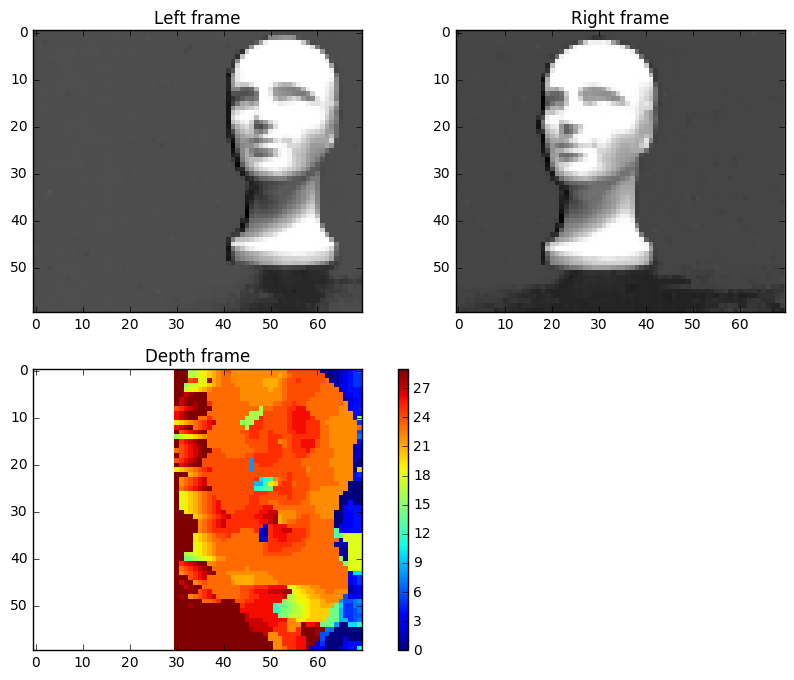

In [23]:
experiments = ('boxes_and_cones_downsampled', 'checkerboard_downsampled', 'head_downsampled')
disparities = (20, 22, 30) # note that these should be scaled if the scale factor in the config file is changed.
experiment_id = 2

experiment_name = experiments[experiment_id]
disparity_max = disparities[experiment_id]

frame_id = 40

print("Sample images from experiment: {}".format(experiment_name))
config = load_config(os.path.join("..", "experiments", "configs", "hybrid", experiment_name + ".yaml"))
left_frames, right_frames, timestamps = load_mrf_frames(config)
left_img = left_frames[frame_id]
right_img = right_frames[frame_id]
depth_map_raw = eval_mrf(left_img, right_img, disparity_max, n_iter=10)
    

**Result Analysis:** 
- _Head experiment_: the head is mostly correctly matched, with some errors in the middle, however if one increases the number of iterations then they disappear. The background on the right seems to be correct, while the one on the left incorrect. If the assumption that ambigous correspondence produces ambigous results holds, then we should not look for hyper-parameter optimization that are tuned to produce different result for this particular image. 
- _Checkerboard experiment_: the outcome of this experiment show that the MRF is producing good results for the regions which can be matched unambigously, such as object edges. The detected disparities for the regions with homogeneuos colors, e.g. the floor or the wall are mostly incorrect. Nevertheless, the pixel correspondece there is not trivially computable and without any additional knowledge, such as "the floor spans perpendicularly to the image plane" no matching algorithm will be able to generate an adequate depth map. In the experiment with the checkerboard, especially difficulty is posed by the repetitive patterns, which in some frames (e.g. No. 40) is fully visible and has therefore a globally optimal matching configuration. This configuration unfortuantely not found by the algorithm.  
- _Boxes and cones experiment_: some depth maps from frames in this dataset are particularly badly computed as they are overexposed and wash out the object edges. It is worth expoliring to pre-process the data in a robust way such that such overexposures are avoided.

## MRF on frames with prior information from SNN output

This experiment will take the pre-computed depth events from the spiking network and will run the MRF on the same data. This time however the initial state of the random field will be computed as a convex combination between the data (i.e. image differences) and the prior. The reader is encouraged to play with the parameters. The arguably well-performing parameters are set as the default in the cell below.

Sample images from experiment: head_downsampled


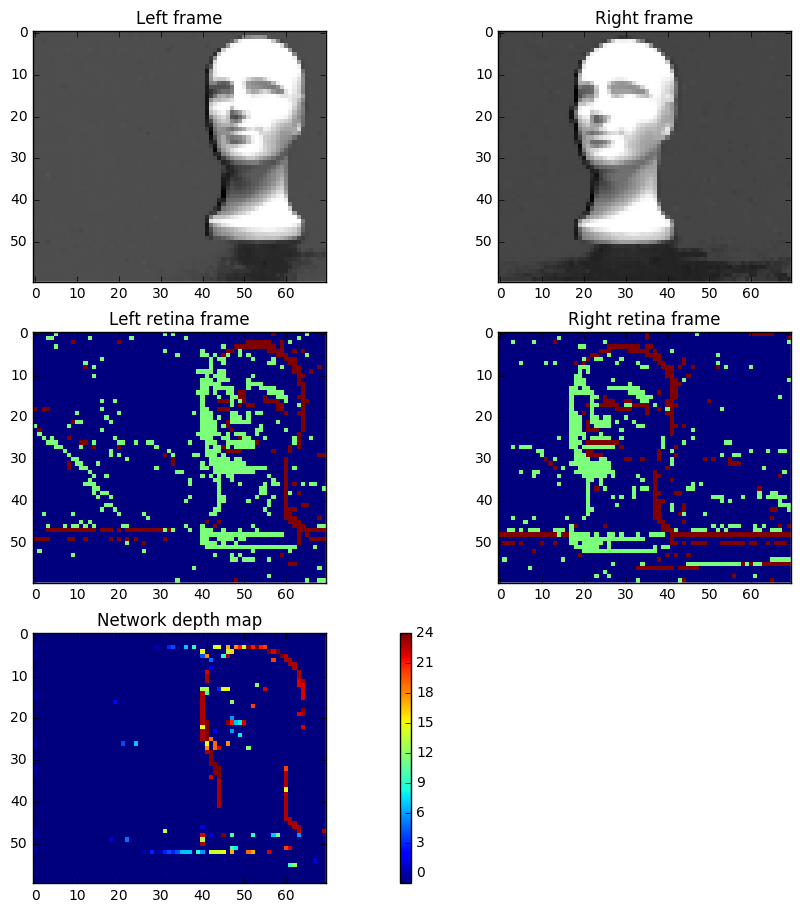

In [24]:
buffer_len = 20  # time in ms

print("Sample images from experiment: {}".format(experiment_name))
config = load_config(os.path.join("..", "experiments", "configs", "hybrid", experiment_name + ".yaml"))
left_frames, right_frames, timestamps = load_mrf_frames(config)
left_img = left_frames[frame_id]
right_img = right_frames[frame_id]

# remove the _downsampled suffix in the experiment name for the pivots
pivots = np.load(os.path.join("..", "data", "input", "frames", experiment_name[:-12], 
                              "left", "timestamps.npy")) / 1000.
retina_spikes, left_retina, right_retina = \
    load_retina_spikes(config, build_frames=True, 
                       pivots=pivots, 
                       buffer_length=buffer_len)
snn_spikes_file = os.path.join("..", "data", "output", "experiments", 
                               "best_snn_spikes", experiment_name + '.pickle')
prior_frames, _, prior_frame_indices = \
    load_snn_spikes(snn_spikes_file, build_frames=True, 
                    pivots=pivots, buffer_length=buffer_len)

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(11, 11)
# fig.tight_layout()

axs[0, 0].imshow(left_img, interpolation='none', cmap='gray')
axs[0, 0].set_title("Left frame")
axs[0, 1].imshow(right_img, interpolation='none', cmap='gray')
axs[0, 1].set_title("Right frame")
axs[1, 0].imshow(left_retina[frame_id], interpolation='none')
axs[1, 0].set_title("Left retina frame")
axs[1, 1].imshow(right_retina[frame_id], interpolation='none')
axs[1, 1].set_title("Right retina frame")
depth_map_snn = axs[2, 0].imshow(prior_frames[frame_id], interpolation='none')
depth_map_pos = axs[2, 0].get_position()
cbaxes = plt.axes([depth_map_pos.x0*1.05 + depth_map_pos.width * 1.05, 
                   depth_map_pos.y0, 0.01, depth_map_pos.height])
fig.colorbar(depth_map_snn, cax=cbaxes)
axs[2, 0].set_title("Network depth map")
axs[2, 1].set_visible(False)
    

The prior frame, obtained from the buffered SNN output in the time interval (`buffer_len` ms) before the actual frames, is mixed with the data-term computed in the image difference operation. The mixing coefficient can be proportional to the difference term, which has the following interpretation: _the lower the matching confidence from the data, the higher the prior influence should be_.  

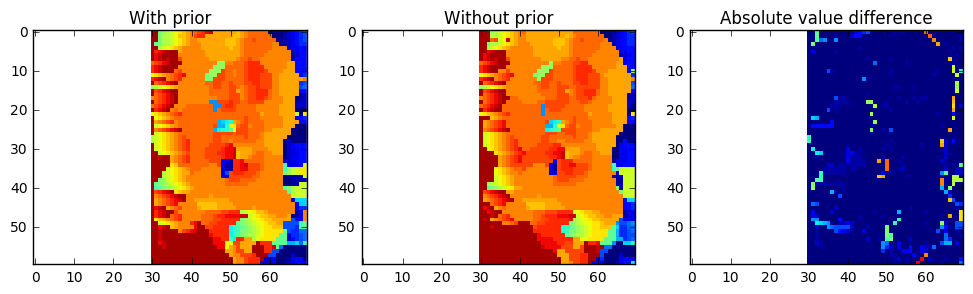

In [21]:
depth_map_prior = eval_mrf(left_img, right_img, disparity_max, 
                           prior=prior_frames[frame_id], 
                           prior_mode='const',   # can also be `adaptive`, but then no exaggerations are possible
                           prior_const=1,
                           n_iter=5, show_plots=False)

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 20)
axs[0].imshow(depth_map_prior, interpolation='none', vmax=disparity_max)
axs[0].set_title("With prior")
axs[1].imshow(depth_map_raw, interpolation='none', vmax=disparity_max)
axs[1].set_title("Without prior")
axs[2].imshow(np.abs(depth_map_raw - depth_map_prior), interpolation='none', vmax=disparity_max)
axs[2].set_title("Absolute value difference")

**Result Analysis**: In most examples the prior has visually deteriorated the results (especially if taken with great influence) and in the rest of the cases it hasn't change much of the quality of the depth map. The former effect is due to the noisy output that the SNN produces on these datasets and latter is due to the sparsity. In any case, these results do not support the claim that using SNN as prior initialisation for the MRF will improve the quality of the depth map.

## Inspecting the spatial precision of the prior
<span style="color:red">In the last minute I found a bug when the shift is applied to the prior (not in the optical flow algorithm) and some results are incorrect. However it doesn't matter too much, as this feature is not used in any case. I will push the fixed version soon.</span>

Since the prior is an accumulated information from the past, and motion is present, it can happend (at least in theory) that the SNN output will have spikes on locations which are slightly off form the gray-scale image. If this is the case (which is not easily detectable in an automatic fashion) then one can try to compute the motion of the object and adapt the SNN output accordingly. An optical flow algorithm on the SNN events is applied to estimate the future posiiton of the object and the shift is added to the prior. 

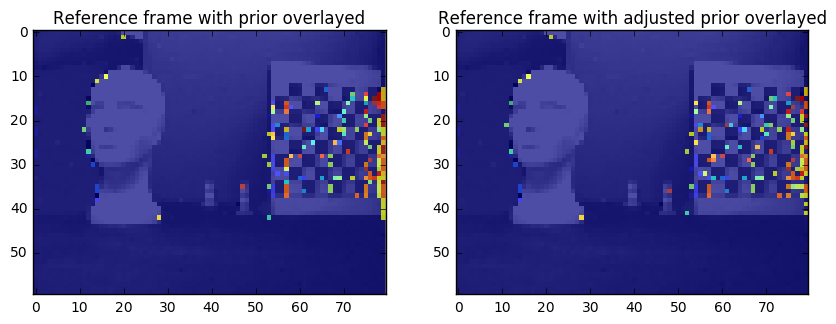

In [6]:
prior_events = load_snn_spikes(snn_spikes_file, build_frames=False, 
                               pivots=pivots, buffer_length=buffer_len)
adjusted_events = adjust_events_from_motion(retina_spikes, prior_frames[frame_id], 
                                            frame_id, left_img.shape, 
                                            pivots, buffer_len)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 16)
axs[0].imshow(left_img, interpolation='none', cmap='gray')
axs[0].imshow(prior_frames[frame_id], interpolation='none', alpha=0.7)
axs[0].set_title("Reference frame with prior overlayed")

# BEWARE: Prior adjustment is flawed, and has to be debugged. Since there is no real need for it, 
# this task is posponed for for later. I will try to fix it ASAP though.

axs[1].imshow(left_img, interpolation='none', cmap='gray')
axs[1].imshow(adjusted_events, interpolation='none', alpha=0.7)
axs[1].set_title("Reference frame with adjusted prior overlayed")

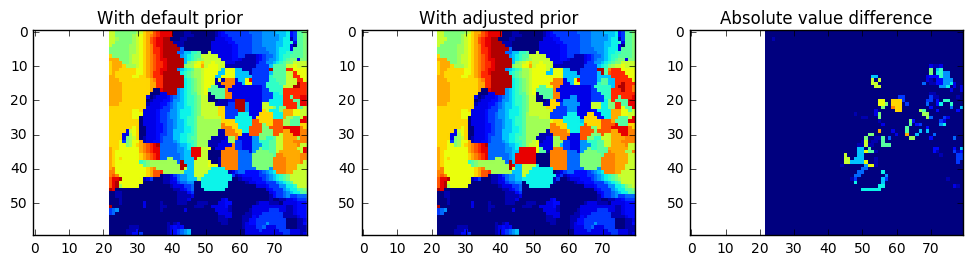

In [7]:
depth_map_prior_adjusted = eval_mrf(left_img, right_img, disparity_max, 
                                    prior=adjusted_events, 
                                    prior_mode='const',   # can be `adaptive`, but then no exaggeration is possible
                                    prior_const=100,
                                    n_iter=5, show_plots=False)

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 20)
axs[0].imshow(depth_map_prior, interpolation='none', vmax=disparity_max)
axs[0].set_title("With default prior")
axs[1].imshow(depth_map_prior_adjusted, interpolation='none', vmax=disparity_max)
axs[1].set_title("With adjusted prior")
axs[2].imshow(np.abs(depth_map_prior - depth_map_prior_adjusted), interpolation='none', vmax=disparity_max)
axs[2].set_title("Absolute value difference")